In [10]:
#1. 搭建的神经网络，使用olivettiface数据集进行训练。
# 结合归一化和正则化来优化网络模型结构

import torch
import torch.nn as nn
from torchvision.transforms.v2 import ToTensor     # 转换图像数据为张量
from sklearn.datasets import fetch_olivetti_faces  # 获取olivetti人脸数据集
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


In [11]:
#定义超参数
learning_rate = 0.001
epochs = 300
batch_size = 64

#GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#定义模型
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4096, 400) #定义三个全连接层
        self.bn1 = nn.BatchNorm1d(400)  #归一化,加速收敛，提高泛化性
        self.fc2 = nn.Linear(400, 400) 
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 40) 
        self.drop = nn.Dropout(p=0.3) #随机丢弃一定比例的节点，防止过拟合(随机失活神经元，减少过拟合)
        self.act = nn.ReLU() #激活函数

    def forward(self, input_tensor):
        out = self.act(self.bn1(self.fc1(input_tensor)))
        out = self.drop(out) #随机失活,需要在传入下一个节点之前
        out = self.act(self.bn2(self.fc2(out)))
        out = self.drop(out)
        result = self.fc3(out)
        return result

cuda:0


In [12]:
# 引入数据
olivetti_faces = fetch_olivetti_faces(data_home='./', shuffle=True)
images = torch.tensor(olivetti_faces.data,dtype=torch.float32)
# print(images.shape)
targets = torch.tensor(olivetti_faces.target,dtype=torch.long)
# print(targets.shape)
dataset = [(img,lbl) for img,lbl in zip(images, targets)]
train_dl = DataLoader(dataset, batch_size = batch_size, shuffle=True)
# print(dataset)



In [13]:
model1 = MyModel().to(device)

# 引入损失函数 + 优化器
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

losses = []
#开始训练
for epoch in range(epochs):
    for data, target in train_dl:
        data = data.reshape(-1, 4096).to(device) #每个样本是一个长度为4096的向量，转换目的是为了匹配模型的输入层
        # print(data.shape)
        target = target.to(device)
        #前向计算
        outputs = model1(data)
        loss = loss_func(outputs, target)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch: {epoch+1}/{epochs}, loss = {loss.item():.4f}")    

epoch: 1/300, loss = 2.6068
epoch: 2/300, loss = 1.7317
epoch: 3/300, loss = 1.3661
epoch: 4/300, loss = 1.2086
epoch: 5/300, loss = 0.6238
epoch: 6/300, loss = 0.6566
epoch: 7/300, loss = 0.3470
epoch: 8/300, loss = 0.3087
epoch: 9/300, loss = 0.4359
epoch: 10/300, loss = 0.2019
epoch: 11/300, loss = 0.2914
epoch: 12/300, loss = 0.1476
epoch: 13/300, loss = 0.0973
epoch: 14/300, loss = 0.1413
epoch: 15/300, loss = 0.0622
epoch: 16/300, loss = 0.0642
epoch: 17/300, loss = 0.0735
epoch: 18/300, loss = 0.0912
epoch: 19/300, loss = 0.0664
epoch: 20/300, loss = 0.0684
epoch: 21/300, loss = 0.0540
epoch: 22/300, loss = 0.0240
epoch: 23/300, loss = 0.0440
epoch: 24/300, loss = 0.0196
epoch: 25/300, loss = 0.0250
epoch: 26/300, loss = 0.0398
epoch: 27/300, loss = 0.0276
epoch: 28/300, loss = 0.0209
epoch: 29/300, loss = 0.0403
epoch: 30/300, loss = 0.0167
epoch: 31/300, loss = 0.0299
epoch: 32/300, loss = 0.0134
epoch: 33/300, loss = 0.0254
epoch: 34/300, loss = 0.0177
epoch: 35/300, loss = 0

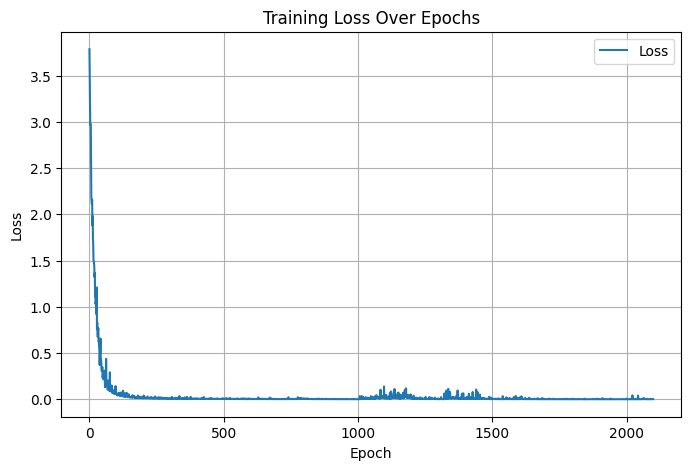

In [14]:
# 画losses 下降曲线图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(0, 2100), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()